# Condensation flux

In this notebook, I compare the condensation flux obtained from experiment with the model in [Jung 2021](https://pubs.acs.org/doi/10.1021/acs.langmuir.1c00473).

## 0 Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks
import cv2
import shutil
from myimagelib.myImageLib import readdata

## 1 Theory: single semi-sphere and semi-cylinder

The model predicts the condensation flux near a bump on a flat surface. The condensation on the bump is currently inaccessible from experiment, so we focus on the flux outside the bump on the flat surface. 

Near a semi-spherical bump, the flux outside the bump is modeled as

$$
J_{sphere} = \frac{x/2}{\sqrt{(x/2)^2 + r^2} },
$$

where $x$ is the distance from the fungal patch center and $r$ is the radius of the fungal patch. 

Near a semi-cylindrical bump, the flux outside the bump is modeled as

$$
J_{cylinder} = 1 - \frac{r^2}{x^2},
$$

Note that the fluxes are all relative to the flux in a canonical case where condensation happens on a pure flat surface. 

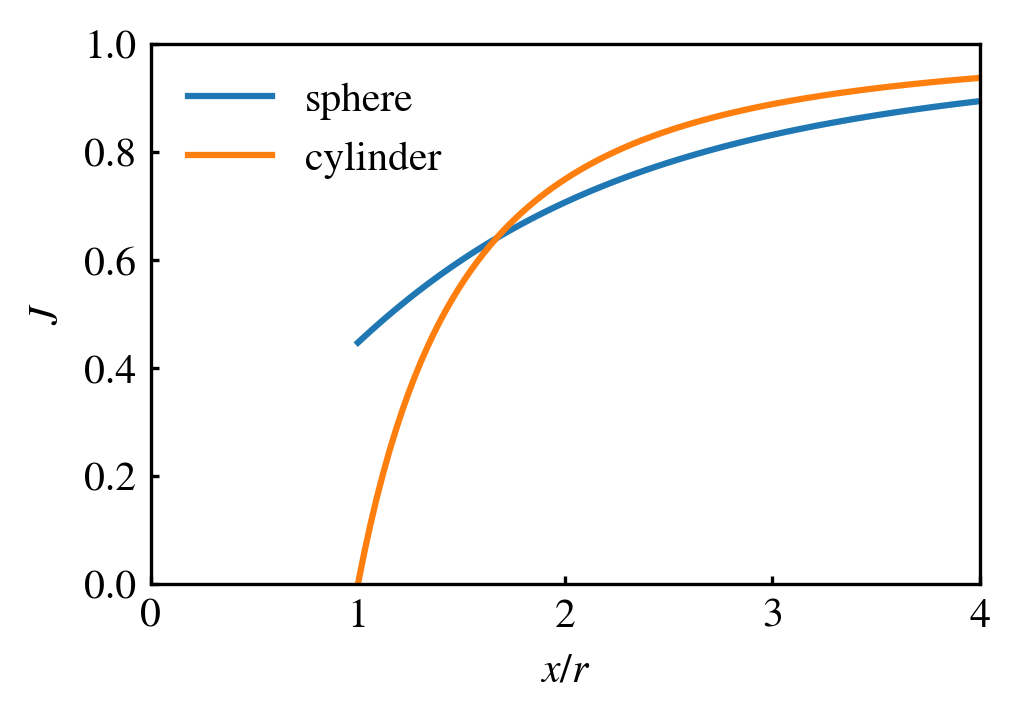

In [12]:
r = 1 # radius of the circle
x = np.linspace(r, 4*r, 100)
J = x/2 / (r**2 + (x/2)**2) ** 0.5 # semi-sphere
J2 = 1 - r**2 / x**2

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
ax.plot(x, J, label=r"sphere")
ax.plot(x, J2, label=r"cylinder")
ax.set_xlabel(r"$x/r$")
ax.set_ylabel(r"$J$")
ax.legend(frameon=False)
ax.set_xlim(0, 4*r)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig("sphere_cylinder.pdf")

## 2 Experiment: droplet detection

Cole has worked on detecting droplets over the summer. The work has mainly been on the video `exp5.avi` on `06282024`. Here, I collect the data from Cole and validate the detection against raw images. I'll also check and combine the hand labeling data to improve the data quality. 

In [13]:
# function to exrtract frames from a video file
def get_frame_from_video(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame {frame_number}")
    return frame

### 2.1 Generate drop detection overlay

In [ ]:
#### set parameters ####
folder = r"G:\My Drive\Research projects\F\Data\06282024"
filename = "exp5"
fns = range(25, 125, 5)
########################

for frame_number in fns:
    video_path = os.path.join(folder, filename+".avi")
    data_path = os.path.join(folder, "tracking", filename, f"{frame_number:04d}.csv")
    frame = get_frame_from_video(video_path, frame_number)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    drops = pd.read_csv(data_path)

    #prepare results
    overlay_frame = frame.copy()
    for i, drop in drops.iterrows():
        x, y, r = drop[["x", "y", "r"]].astype(int)
        cv2.circle(overlay_frame, (x, y), r, (0, 255, 255), 3)

    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    ax.imshow(cv2.cvtColor(overlay_frame, cv2.COLOR_BGR2RGB))
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(os.path.join(folder, "tracking", filename, f"{frame_number:04d}.jpg"))

### 2.2 Drop number, mean size and flux

Plot total droplet number and mean radius of droplets over time.

In [69]:
folder = r"G:\My Drive\Research projects\F\Data\06282024\tracking\exp5"
l = readdata(folder, "csv")
mpp = 2.3 # microns per pixel
fps = 0.05 # frame per second
x0, y0, r0 = 1968, 1532, 650 # fungal patch location and radius

total_drops = []
mean_size = []
t = []
for num, i in l.iterrows():
    xyr = pd.read_csv(i.Dir)
    total_drops.append(len(xyr))
    mean_size.append(xyr.r.mean()*mpp)
    t.append(float(i.Name)/fps)
    # convert to polar coordinates
    xyr["R"] = ((xyr.x - x0)**2 + (xyr.y - y0)**2) ** 0.5

(0.0, 40.0)

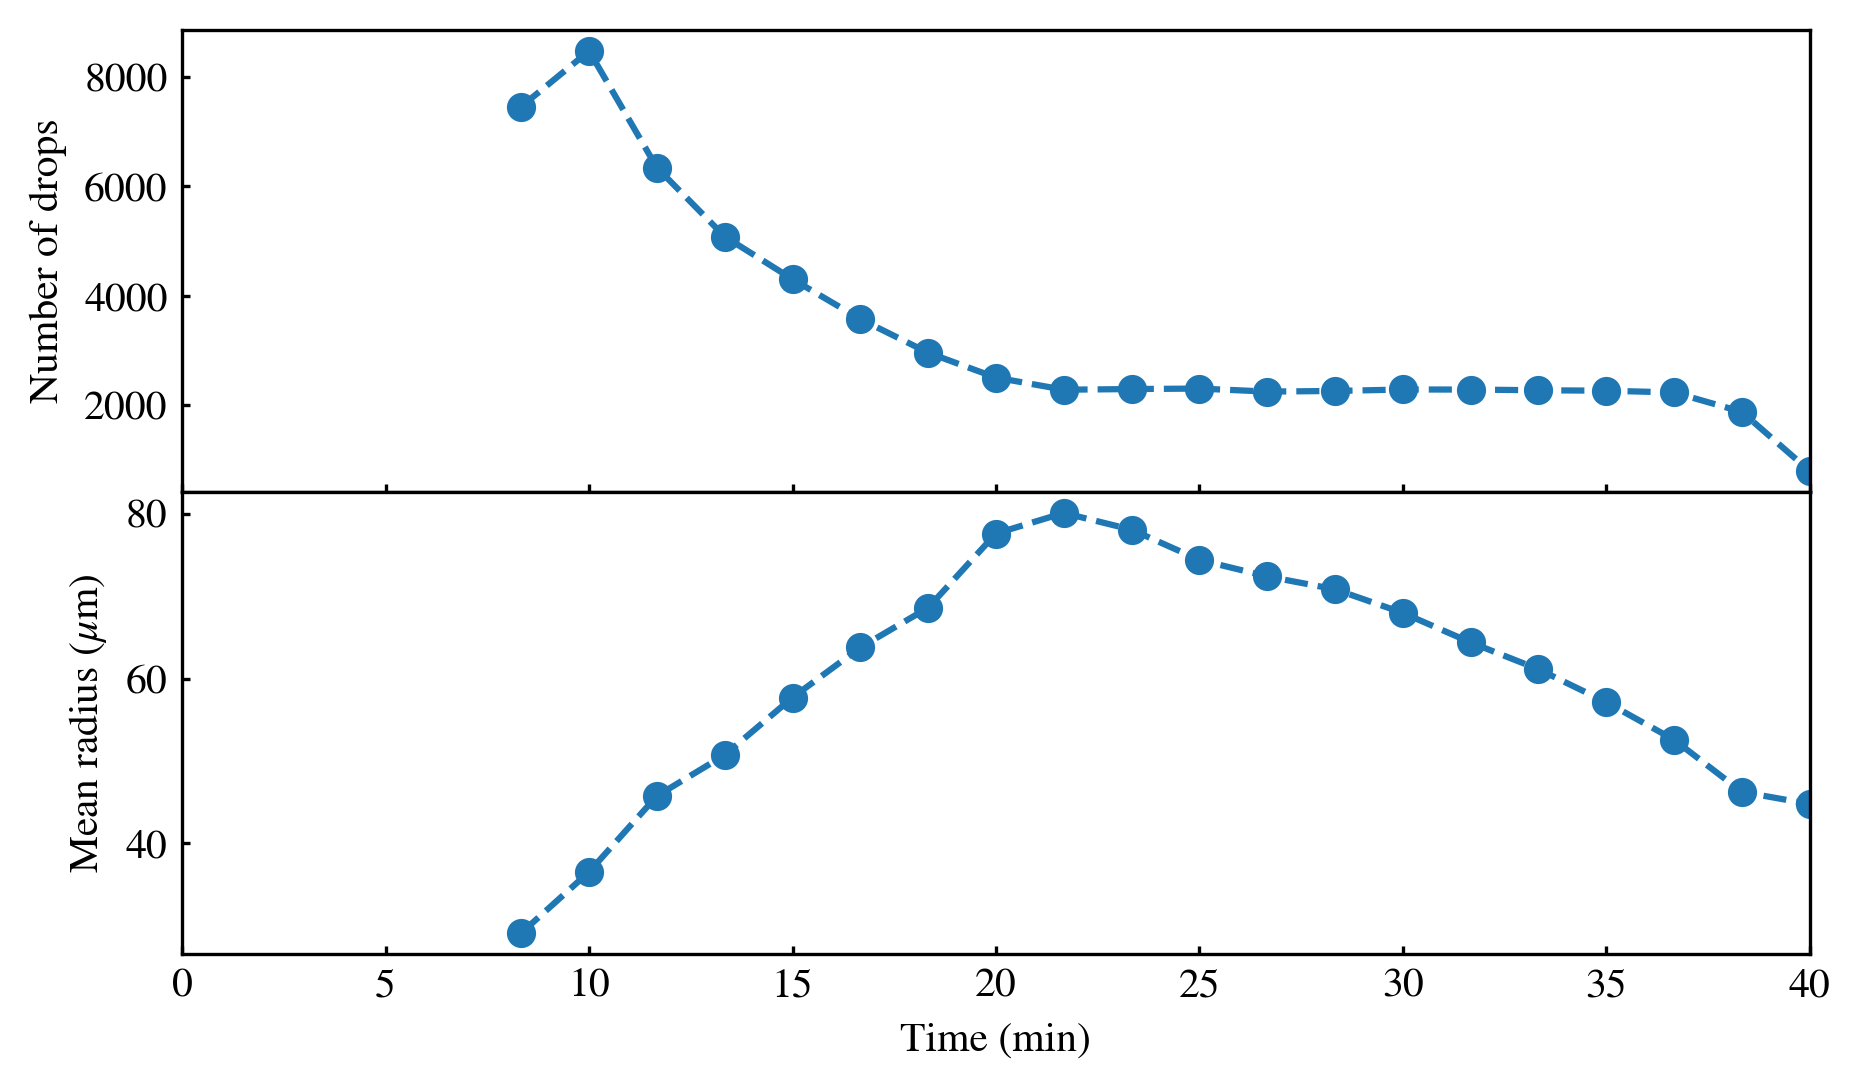

In [78]:
fig, ax = plt.subplots(nrows=2, figsize=(7, 4), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
ax[0].plot(np.array(t)/60, total_drops, ls="--", marker="o")
ax[0].set_ylabel("Number of drops")
ax[1].plot(np.array(t)/60, mean_size, ls="--", marker="o")
ax[1].set_ylabel("Mean radius ($\mu$m)")
ax[1].set_xlabel("Time (min)")
ax[1].set_xlim(0, 40)

Plot the droplet total volume vs. time in distance bins.

In [165]:
folder = r"G:\My Drive\Research projects\F\Data\06282024\tracking\exp5"
l = readdata(folder, "csv")
mpp = 2.3 # microns per pixel
fps = 0.05 # frame per second
x0, y0, r0 = 1968, 1532, 600 # fungal patch location and radius
bins = np.linspace(r0, 3*r0, 10)

data = {}
for num, i in l.iterrows():
    xyr = pd.read_csv(i.Dir)
    xyr["R"] = ((xyr.x - x0)**2 + (xyr.y - y0)**2) ** 0.5
    data[i.Name] = []
    for j in range(len(bins)-1):
        sub_xyr = xyr[(xyr.R >= bins[j]) & (xyr.R < bins[j+1])]
        data[i.Name].append(((sub_xyr.r*mpp*1e-3)**3 * np.pi * 2/3).sum())

In [167]:
df = pd.DataFrame(data, index=bins[:-1]/r0, columns=l.Name)
area = 2 * np.pi * (kw*r0*mpp*1e-3) * dr

In [187]:
# compute flux from volume
dr = (bins[1] - bins[0]) * mpp * 1e-3
dt = 5 / fps / 60

flux = pd.DataFrame()
for kw in df.T:
    area = 2 * np.pi * (kw*r0*mpp*1e-3) * dr
    flux[kw] = (df.T[kw].diff() / area / dt)

In [189]:
flux = flux.T

In [190]:
flux

Name,0025,0030,0035,0040,0045,0050,0055,0060,0065,0070,0075,0080,0085,0090,0095,0100,0105,0110,0115,0120
1.000000,NaN,0.003103,0.001956,0.002323,0.003252,0.000878,0.001369,0.001404,-0.000262,-0.000252,-0.002272,-0.000916,-0.000931,-0.000992,-0.001151,-0.000345,-0.001155,-0.001723,-0.002817,-0.001789
1.222222,NaN,0.006019,0.003811,0.003329,0.003335,0.004484,-0.001227,0.004844,-0.000610,-0.002372,-0.004952,-0.000042,-0.000595,-0.001103,-0.003375,-0.002292,-0.002376,-0.001711,-0.003634,-0.004517
1.444444,NaN,0.005564,0.005440,0.002171,0.004228,0.002926,0.000556,0.005896,-0.002086,-0.000411,-0.006733,-0.001049,-0.001619,-0.002182,-0.002028,-0.001679,-0.002903,-0.002112,-0.003044,-0.005024
1.666667,NaN,0.006071,0.005585,0.001019,0.004190,0.002422,0.001050,0.004633,-0.000704,-0.001783,-0.003940,-0.001887,-0.001698,-0.002491,-0.002572,-0.002014,-0.002609,-0.002232,-0.003569,-0.003887
1.888889,NaN,0.005918,0.006736,0.000087,0.004287,0.002473,-0.000203,0.005683,0.000552,-0.001998,-0.004902,-0.001079,-0.002268,-0.002153,-0.002480,-0.002676,-0.002495,-0.002395,-0.003636,-0.003500
2.111111,NaN,0.005982,0.005873,0.001327,0.004516,0.001494,-0.000896,0.008067,0.000180,-0.003598,-0.004230,-0.001643,-0.002628,-0.001850,-0.002532,-0.002239,-0.002403,-0.002523,-0.003878,-0.003403
2.333333,NaN,0.005844,0.005249,0.000564,0.003672,0.002592,0.001096,0.005553,-0.000322,-0.002712,-0.002453,-0.003955,0.000235,-0.002514,-0.003274,-0.001803,-0.002499,-0.002235,-0.004224,-0.003170
2.555556,NaN,0.004514,0.005255,0.000272,0.002943,0.001793,0.000385,0.004982,-0.000597,-0.001216,-0.003148,-0.000871,-0.001763,-0.002206,-0.001804,-0.001976,-0.001775,-0.002105,-0.002978,-0.002471
2.777778,NaN,0.004240,0.003851,0.000167,0.003115,0.001856,-0.000392,0.004308,0.000461,-0.001663,-0.003653,-0.001191,-0.001010,-0.001002,-0.001721,-0.001876,-0.001730,-0.001773,-0.002205,-0.002298


C:\Users\zl948\AppData\Local\Temp\ipykernel_109300\977683125.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("winter")


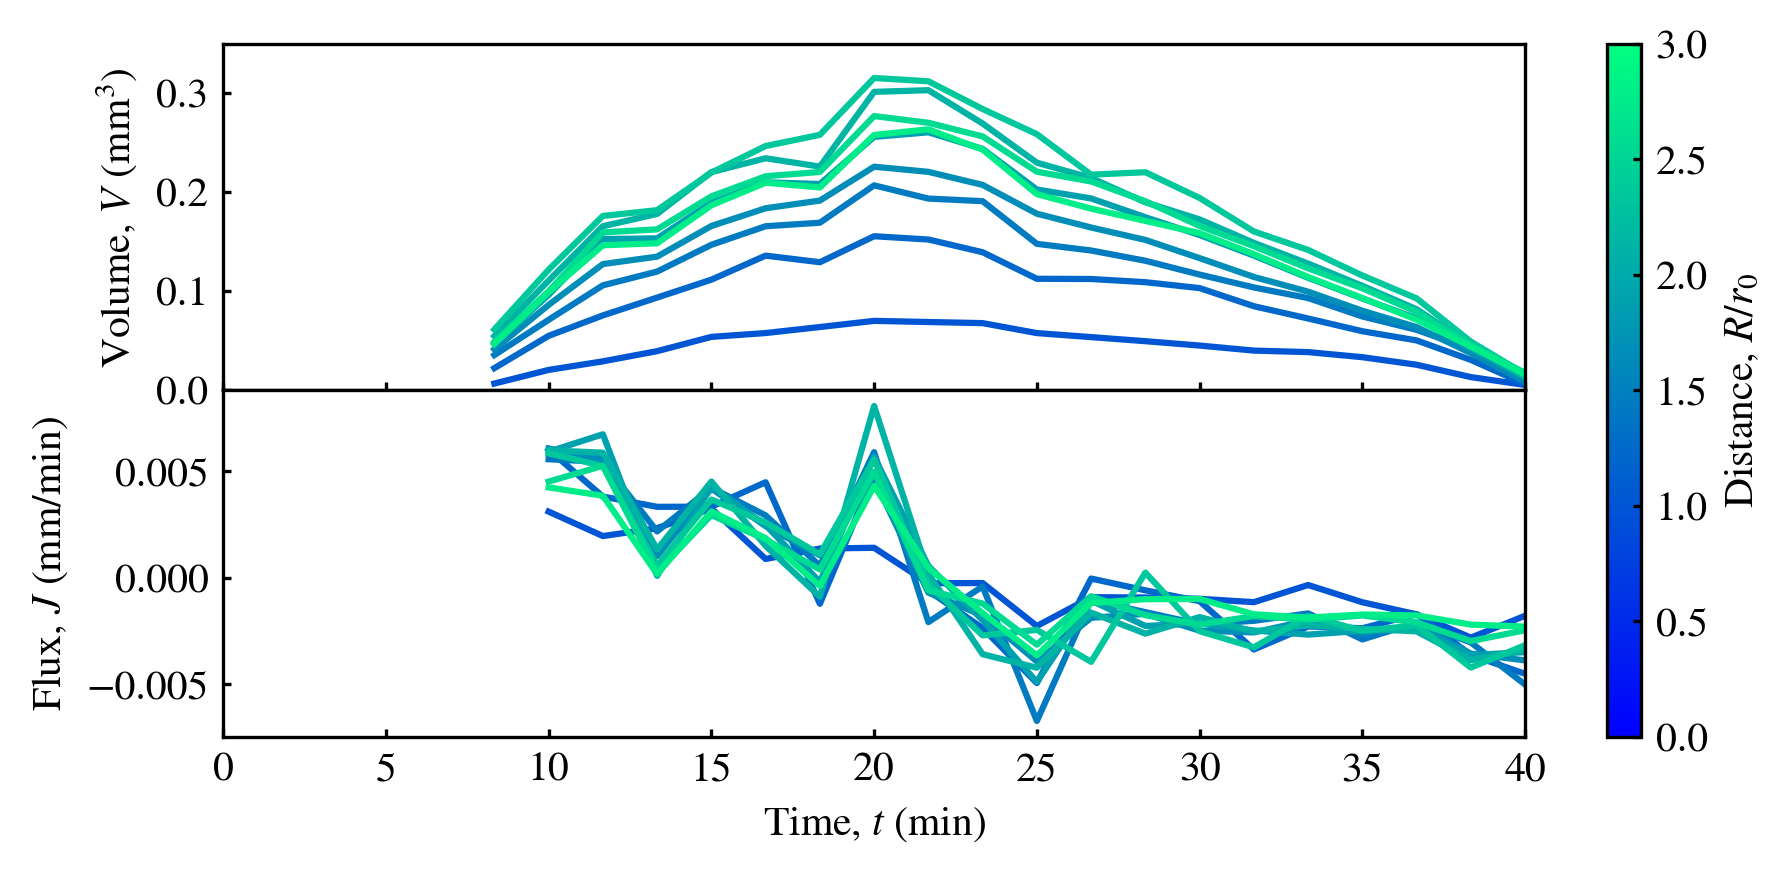

In [192]:
fig, ax = plt.subplots(nrows=2, figsize=(7, 3), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
cmap = plt.cm.get_cmap("winter")
for kw in df.T:
    t = df.T.index.astype(float)/fps/60 # in min
    ax[0].plot(t, df.T[kw], color=cmap(kw/3), label=f"${kw:.1f}$")
    ax[1].plot(t, flux.T[kw], color=cmap(kw/3), label=f"${kw:.1f}$")
# ax.legend(frameon=False, title="Distance ($r_0$)")
# generate a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 3))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Distance, $R/r_0$")
# plt.colorbar(sm, ax=ax[1], label="Distance, $R/r_0$")
ax[0].set_xlim([0, 40])
ax[0].set_ylim([0, 0.35])
ax[1].set_xlabel("Time, $t$ (min)")
ax[0].set_ylabel("Volume, $V$ (mm$^3$)")
ax[1].set_ylabel("Flux, $J$ (mm/min)")
# plt.tight_layout()
fig.savefig("volume_vs_time.pdf")

In [193]:
flux.head()

Name,0025,0030,0035,0040,0045,0050,0055,0060,0065,0070,0075,0080,0085,0090,0095,0100,0105,0110,0115,0120
1.000000,NaN,0.003103,0.001956,0.002323,0.003252,0.000878,0.001369,0.001404,-0.000262,-0.000252,-0.002272,-0.000916,-0.000931,-0.000992,-0.001151,-0.000345,-0.001155,-0.001723,-0.002817,-0.001789
1.222222,NaN,0.006019,0.003811,0.003329,0.003335,0.004484,-0.001227,0.004844,-0.000610,-0.002372,-0.004952,-0.000042,-0.000595,-0.001103,-0.003375,-0.002292,-0.002376,-0.001711,-0.003634,-0.004517
1.444444,NaN,0.005564,0.005440,0.002171,0.004228,0.002926,0.000556,0.005896,-0.002086,-0.000411,-0.006733,-0.001049,-0.001619,-0.002182,-0.002028,-0.001679,-0.002903,-0.002112,-0.003044,-0.005024
1.666667,NaN,0.006071,0.005585,0.001019,0.004190,0.002422,0.001050,0.004633,-0.000704,-0.001783,-0.003940,-0.001887,-0.001698,-0.002491,-0.002572,-0.002014,-0.002609,-0.002232,-0.003569,-0.003887
1.888889,NaN,0.005918,0.006736,0.000087,0.004287,0.002473,-0.000203,0.005683,0.000552,-0.001998,-0.004902,-0.001079,-0.002268,-0.002153,-0.002480,-0.002676,-0.002495,-0.002395,-0.003636,-0.003500


C:\Users\zl948\AppData\Local\Temp\ipykernel_109300\1045779111.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis")


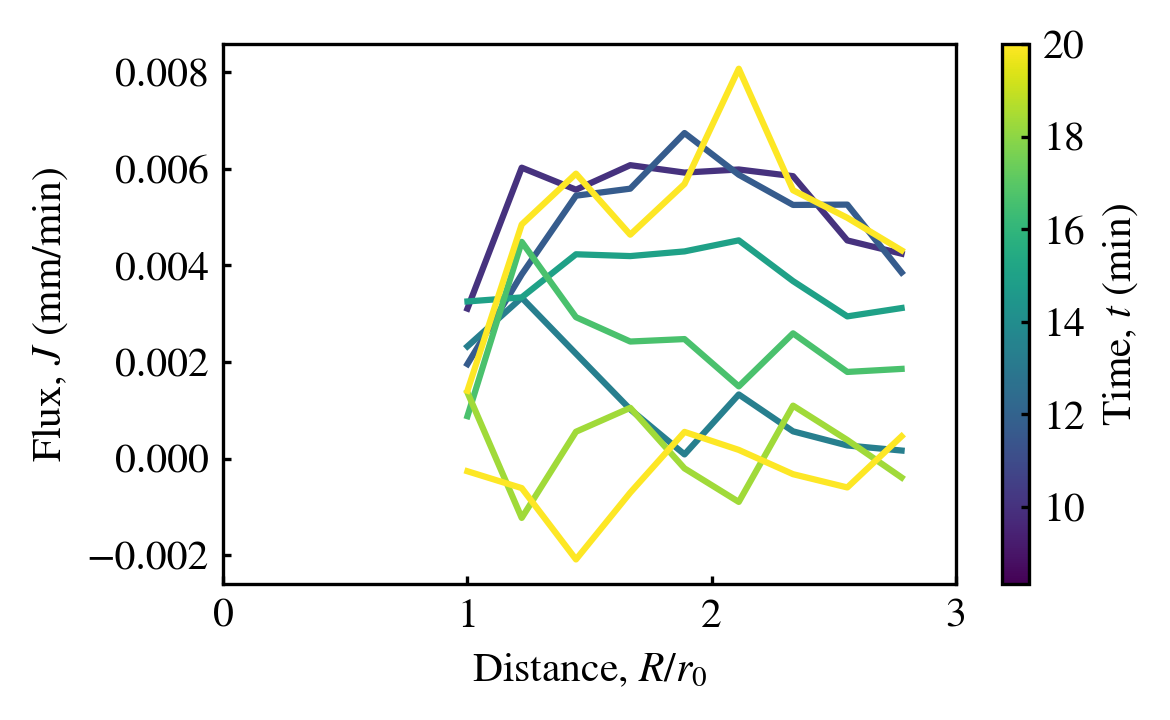

In [209]:
# plot flux as a function of distance
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=300)
cmap = plt.cm.get_cmap("viridis")
for kw in flux:
    ax.plot(flux.index.astype(float), flux[kw], color=cmap((float(kw)-25)/35), label=f"${float(kw)/fps/60}$")
    if float(kw) > 60:
        break

ax.set_xlabel("Distance, $R/r_0$")
ax.set_ylabel("Flux, $J$ (mm/min)")
# ax.set_xlim([0, 3])
# ax.legend(frameon=False, title="Distance ($r_0$)")
# generate a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(25/fps/60, 60/fps/60))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Time, $t$ (min)")
ax.set_xlim([0, 3])
plt.tight_layout()
fig.savefig("flux_vs_distance.pdf")

(-5.5, 5.5, -0.24996853191846877, 5.249339170287843)

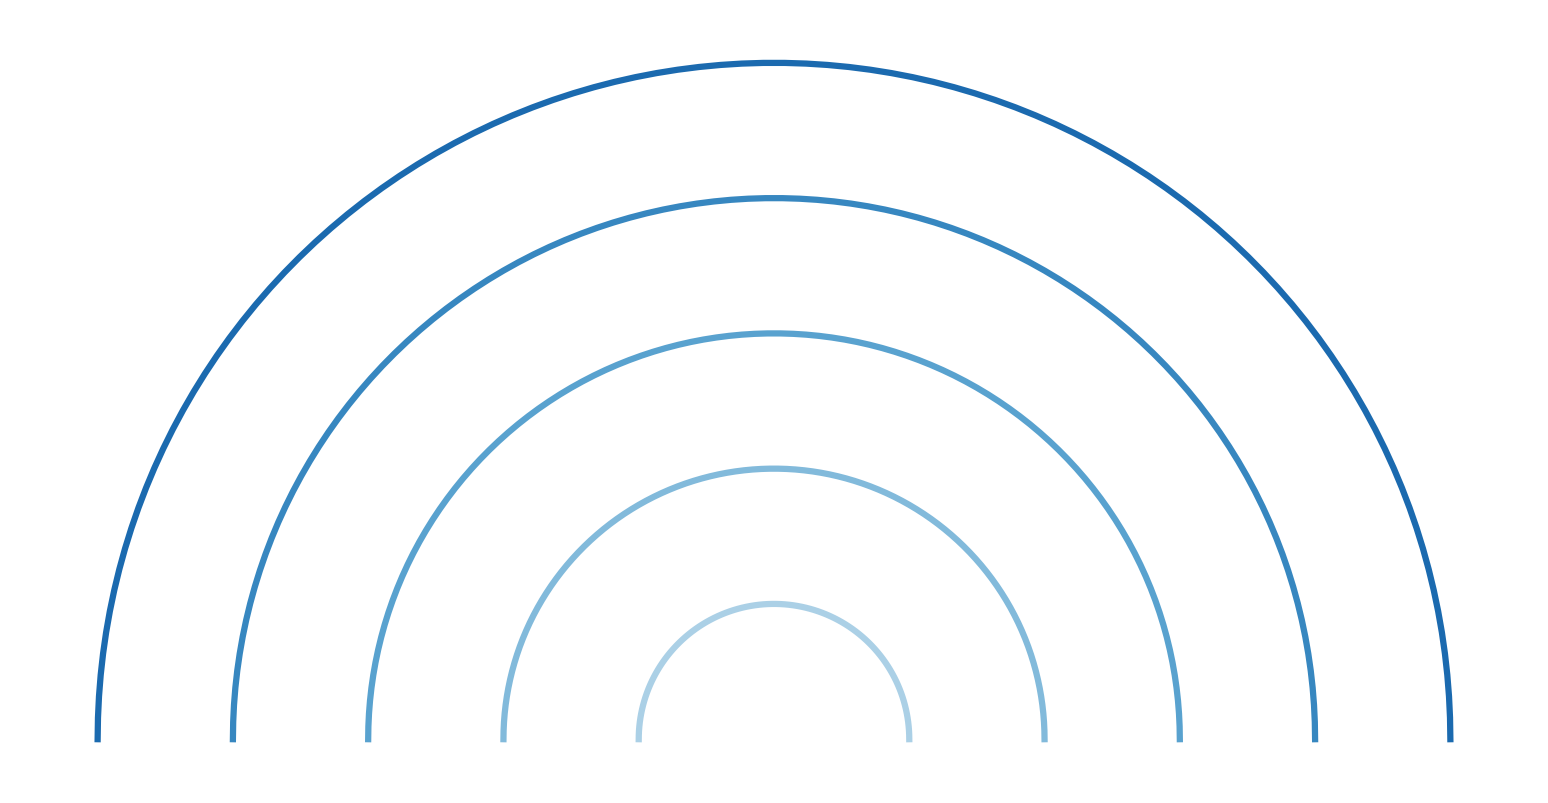

In [9]:
# draw a few concentric hemisphere with different radii, color them using viridis colormap

def create_semicircle(radius, num_points=100):
    theta = np.linspace(0, np.pi, num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y

# Step 3: Generate multiple semicircles with different radii
radii = [1, 2, 3, 4, 5]
colors = plt.get_cmap("Blues", 10)

# Step 4: Use the Viridis colormap to color the semicircles
fig, ax = plt.subplots(dpi=300)
i = 3
for radius in radii:
    x, y = create_semicircle(radius)
    ax.plot(x, y, color=colors(i))
    i += 1

# Step 5: Plot the semicircles using matplotlib
ax.set_aspect('equal')
ax.axis('off')

# generate colorbar



## Appendix A. Extract hand labeling data

In [43]:
# I have a folder, in which there are subfolders containing images, detection and information text files
# I want to read the information text files and save the frame number information to a list

folder = r"G:\My Drive\Research projects\F\Data\hand_labeling_data"
save_folder = r"G:\My Drive\Research projects\F\Data\06282024\tracking"
tar_date = "062824"
tar_title = "exp5.mp4"

os.makedirs(save_folder, exist_ok=True)
sfL = next(os.walk(folder))[1]

frame_list = []
for sf in sfL: 
    data_path = os.path.join(folder, sf, "info.txt")
    with open(data_path, "r") as f:
        lines = f.readlines()
        date = lines[0].strip().split(":")[-1].strip()
        title = lines[1].strip().split(":")[-1].strip()
        if date == tar_date and title == tar_title:
            frame_number = int(lines[2].strip().split(":")[-1])
            prelim_file = os.path.join(folder, sf, "prelim_detection.csv")
            hand_file = os.path.join(folder, sf, "hand.csv")
            if os.path.exists(hand_file):
                shutil.copy(hand_file, os.path.join(save_folder, f"{frame_number:04d}.csv"))
            else:
                shutil.copy(prelim_file, os.path.join(save_folder, f"{frame_number:04d}.csv"))

## Appendix B. Total volume decreases during condensation

